In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import healpy as hp
from scipy.interpolate import interp1d

nside = 1024
lmax = 1024*3-1

def iqu2teb(IQU, nside, lmax=None):
    print('a')
    alms = hp.map2alm(IQU, lmax=lmax, pol=True)
    print('b')
    return hp.alm2map(alms, nside=nside, lmax=lmax, pol=False)

def teb2iqu(TEB, nside, lmax=None):
    alms = hp.map2alm(TEB, lmax=lmax, pol=False)
    return hp.alm2map(alms, nside=nside, lmax=lmax, pol=True)

# Begin in Q, U 
### $a_{Q,U} = R \ a_{E,B} + n_{Q,U}$
### $d_{Q,U} = s_{Q,U} + n_{Q,U}$ 
### $\boldsymbol{d} = \boldsymbol{s} + \boldsymbol{n}$


# Algorithm
### $t = T/(T+N) \ d + \bar{N}/(\bar{N} + T) \  s $
### $ s = S/(S+T) \ t $


# Definitions
### $N_{Q,U} = \langle n_{Q,U} n_{Q,U}^\dagger  \rangle $
### $\bar{N} = N - T$
### $ T = \tau \times \mathbf{1}$ , where $\tau = {\rm{min}} \big( N \big)$

# Signal covariance [EE,BB]

In [32]:
s_cov_diag = np.load('s_cov_EE_1024.npy')
s_cov_diag = np.hstack([s_cov_diag, (s_cov_diag*0.) + np.min(s_cov_diag)*1e-10])

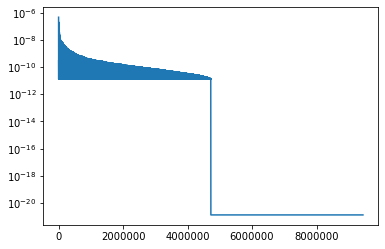

In [33]:
_ = plt.plot(s_cov_diag), plt.yscale('log')

# Data

In [34]:
data_QU = hp.read_map('./map_mock_des1024_QU.fits', field=(0,1))
data_vec = data_QU[0] + 1j* data_QU[1]

NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


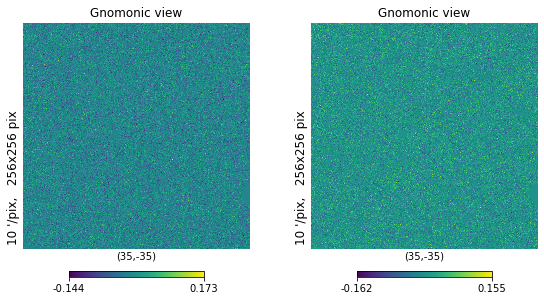

In [35]:
_ = plt.figure(figsize = (12,4)), hp.gnomview(data_vec.real, sub=(1,3,2), reso=10, rot = (35,-35), xsize=256)
_ = hp.gnomview(data_vec.imag, sub=(1,3,3), reso=10, rot = (35,-35), xsize=256)

# Noise covariance $N =  N_{QQ}, N_{UU} $

In [36]:
noise_diag = hp.read_map('map_noise_cov_des1024_QU.fits', field=(0,1))
noise_diag = np.concatenate([noise_diag[0],noise_diag[1]])

NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [37]:
tau = np.min(noise_diag)
print(tau)
T_pixel = np.ones(noise_diag.shape)*tau
noise_bar_diag = noise_diag - tau

0.00017164225573651493


In [38]:
random_T_field = np.random.normal(0., np.sqrt(tau), hp.nside2npix(nside))

In [39]:
power_t_qq = hp.anafast(hp.ud_grade(random_T_field,nside), lmax = nside*3-1)
power_t_pol = hp.anafast([random_T_field*0.,random_T_field,random_T_field],
                          lmax = nside*3-1, pol = True)
tau_ell = np.mean([power_t_pol[1][50:nside*2], power_t_pol[2][50:nside*2], power_t_qq[50:nside*2]]) 

In [40]:
tau_ell

1.7152837829298017e-10

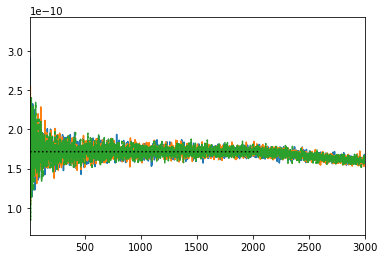

In [41]:
plt.plot(power_t_pol[1])
plt.plot(power_t_pol[2])
plt.plot([tau_ell]*nside*2, ':', c='black')
plt.plot(power_t_qq, '--'), plt.xlim(10,3000)
_ = plt.ylim(np.min(power_t_pol[2][50:nside*2])*0.5,np.max(power_t_pol[2][50:nside*2])*1.5)
plt.plot([tau_ell]*nside*2, ':', c='black')

In [43]:
T_ell = np.ones(s_cov_diag.shape)*tau_ell

# Implementation

In [44]:
n_iter = 10
data_vec_QU = np.concatenate([data_vec.real, data_vec.imag])
s = np.zeros(data_vec_QU.shape, dtype='complex')

convergence_test = [0.]


harmonic_operator = s_cov_diag/(s_cov_diag+T_ell)
pixel_operator_signal = (noise_bar_diag/(noise_bar_diag+T_pixel))
pixel_operator_data = (T_pixel / (T_pixel + noise_diag))

for i in range(n_iter):
    
    t = pixel_operator_data * data_vec_QU + pixel_operator_signal*s # here t = concat[t_Q, t_U]
#     print(np.max(t.imag))
    t = np.real(t)
    t = [t[int(t.shape[0]/2):]*0.,t[:int(t.shape[0]/2)],t[int(t.shape[0]/2):]] # here t = {t_I = 0, t_Q, t_U}
    t = hp.ud_grade(t, nside) # now upgrade
    
    t_alm = hp.map2alm(t, lmax = 3*(nside)-1, pol=True) 
    
#     print(np.max(t_alm[0]))
#     print(np.max(t_alm[1]))
#     print(np.max(t_alm[2]))
    
    s = harmonic_operator*np.concatenate([t_alm[1], t_alm[2]])
    s = [s[int(s.shape[0]/2):]*0.,s[:int(s.shape[0]/2)],s[int(s.shape[0]/2):]]
    
    print(np.var(s[0]), np.var(s[1]), np.var(s[2]))
    convergence_test.append(np.var(s[1]))
    

    s = hp.alm2map(s, nside=nside, lmax=nside*3-1, verbose=False, pol=True)
    s_qu = np.copy(s)
    s = np.concatenate([s[1], s[2]])

0.0 1.9134618230414234e-13 1.5278365922348273e-34
0.0 3.824833950441115e-13 1.5251201221393925e-34
0.0 5.193213175820813e-13 1.5242710444995042e-34
0.0 6.183675015162696e-13 1.5238794658737413e-34
0.0 6.9143347933608e-13 1.5236575010134575e-34
0.0 7.461519917015224e-13 1.5235163346773737e-34
0.0 7.87635567812363e-13 1.5234199010398846e-34
0.0 8.194254431167008e-13 1.523350752853798e-34
0.0 8.440322861422289e-13 1.5232994025688794e-34
0.0 8.632649547428458e-13 1.5232602434905137e-34


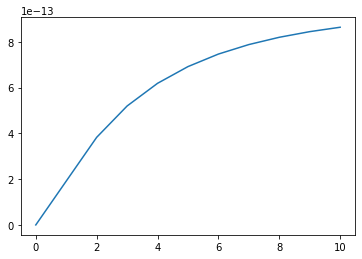

In [45]:
plt.plot(convergence_test)

In [46]:
# s_eb = iqu2teb(hp.ud_grade(s_qu,nside*2), nside*2, lmax = nside*2*3 -1)
# s_eb = hp.ud_grade(s_eb,nside)

s_eb = iqu2teb(s_qu, nside, lmax = nside*3 -1)

a
b
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


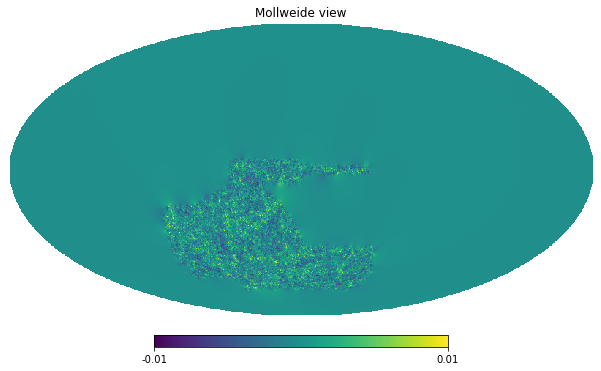

In [47]:
hp.mollview(s_eb[1], min = -0.01, max = 0.01)

In [51]:
np.save('test_wiener2_E_180320', np.array(s_eb[1], dtype = 'float'))